In [171]:
import numpy as np
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.io import fits
import photutils
from photutils import DAOStarFinder
from photutils import IRAFStarFinder
from photutils import find_peaks
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture
from photutils import CircularAnnulus
import random
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from scipy.optimize import curve_fit
#for psf photometry
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf import IterativelySubtractedPSFPhotometry
from astropy.table import Table
from photutils.psf import BasicPSFPhotometry
from astropy.modeling import models, fitting

# Import Object Parameters

In [2]:
objects, ids, RA, Dec, Mag, sed, param1, param2, param3, param4, param5, param6, param7, param8, param9, param10, param11= np.genfromtxt("/home/nrc24/LSST_Project/ra_dec_mag",delimiter=" ", unpack=True)

# PSF Photometry Test

In [304]:
def PSF_Test_IntGaus(RA_array, Dec_array, Mag_array, seeing, passband, circular_aperture_radius):
    hdulist = fits.open("s="+seeing+"_p="+passband+"_gauss.fits.gz")
    image = hdulist[0].data
    w = astropy.wcs.WCS(hdulist[0].header, hdulist)
    hdulist.close()
    xcenters=[]
    ycenters=[]
    for i in range(len(RA_array)):
        ra=RA_array[i]
        dec=Dec_array[i]
        x, y = w.all_world2pix(ra,dec,0) #(ra, dec, origin)
        xcenters=np.append(xcenters,x)
        ycenters=np.append(ycenters, y)
    
    positions = np.column_stack((xcenters,ycenters))
    
    f,(ax1,ax2, ax3)=plt.subplots(1,3)
    #ZOOM INTO JUST 1 STAR
    y_bound_lower=int(ycenters[1]-50)
    y_bound_upper=int(ycenters[1]+50)
    x_bound_lower=int(xcenters[1]-50)
    x_bound_upper=int(xcenters[1]+50)
    cropped_image=image[y_bound_lower:y_bound_upper, x_bound_lower:x_bound_upper]
    x_cropped=xcenters[1]-x_bound_lower
    y_cropped=ycenters[1]-y_bound_lower
    im1=ax1.imshow(cropped_image, cmap='gray')
    ax1.set_title('Original Image')
    f.colorbar(im1, ax=ax1, orientation='horizontal')
    
    #fit the psf's gaussian sigma
    ydim,xdim=cropped_image.shape
    y, x = np.mgrid[:ydim, :xdim]
    z=cropped_image[y,x]
    g_init = models.Gaussian2D(amplitude=1., x_mean=x_cropped, y_mean=y_cropped, x_stddev=2.0, y_stddev=2.0)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, y, z)
    avg_std=0.5*(g.x_stddev.value +g.y_stddev.value)
    print(avg_std)
    im2=ax2.imshow(z, cmap='gray')
    ax2.set_title('Gaussian Fit to PSF')
    f.colorbar(im2, ax=ax2, orientation='horizontal')
    psf_model = IntegratedGaussianPRF()
    psf_model.sigma.fixed = False
    psf_model.sigma.value = 2.209
    #for non-gauss optimal sigma was 2.27
    
    #psf photometry
    sigma_psf = 2.0
    bkgrms = MADStdBackgroundRMS()
    std = bkgrms(cropped_image)
    daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
    mmm_bkg = MMMBackground()
    fitter = LevMarLSQFitter()
    psf_model.x_0.fixed = True #for fixed centroids
    psf_model.y_0.fixed = True
    sources = Table()
    pos = Table(names=['x_0', 'y_0'], data=[[x_cropped],[y_cropped]])
    photometry = BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg, psf_model=psf_model, fitter=LevMarLSQFitter(), fitshape=(15,15))
    result_tab = photometry(image=cropped_image, init_guesses=pos)
    print('x centroid= ', result_tab['x_0'][0])
    print('y centroid= ', result_tab['y_0'][0])
    print('flux_guess= ', result_tab['flux_0'][0])
    print('sigma_guess= ', result_tab['sigma_0'][0])
    print('id= ', result_tab['id'][0])
    print('group_id= ', result_tab['group_id'][0])
    print('x_fit= ', result_tab['x_fit'][0])
    print('y_fit= ', result_tab['y_fit'][0])
    print('flux_fit= ', result_tab['flux_fit'][0])
    print('sigma_fit= ', result_tab['sigma_fit'][0])
    print('flux_uncertainty= ', result_tab['flux_unc'][0])
    print('sigma_uncertainty= ', result_tab['sigma_unc'][0])
    
    #plot residual image
    residual_image = photometry.get_residual_image()
    im3=ax3.imshow(residual_image, cmap='gray')
    ax3.set_title('Residual Image')
    f.colorbar(im3, ax=ax3, orientation='horizontal')

120.22070959494889
x centroid=  50.910462547892166
y centroid=  50.91035620815916
flux_guess=  171575.41569241203
sigma_guess=  2.209
id=  1
group_id=  1
x_fit=  50.910462547892166
y_fit=  50.91035620815916
flux_fit=  184627.52842431114
sigma_fit=  2.209399069769628
flux_uncertainty=  648.4083308343148
sigma_uncertainty=  0.005582125829022338


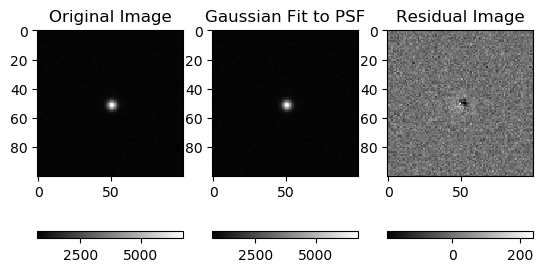

In [305]:
PSF_Test_IntGaus(RA, Dec, Mag, '1.0', "2", 15.0)

In [326]:
def PSF_Test_Gaus2D(RA_array, Dec_array, Mag_array, seeing, passband, circular_aperture_radius):
    hdulist = fits.open("s="+seeing+"_p="+passband+"_gauss.fits.gz")
    image = hdulist[0].data
    w = astropy.wcs.WCS(hdulist[0].header, hdulist)
    hdulist.close()
    xcenters=[]
    ycenters=[]
    for i in range(len(RA_array)):
        ra=RA_array[i]
        dec=Dec_array[i]
        x, y = w.all_world2pix(ra,dec,0) #(ra, dec, origin)
        xcenters=np.append(xcenters,x)
        ycenters=np.append(ycenters, y)
    
    positions = np.column_stack((xcenters,ycenters))
    
    f,(ax1,ax2, ax3)=plt.subplots(1,3)
    #ZOOM INTO JUST 1 STAR
    y_bound_lower=int(ycenters[1]-50)
    y_bound_upper=int(ycenters[1]+50)
    x_bound_lower=int(xcenters[1]-50)
    x_bound_upper=int(xcenters[1]+50)
    cropped_image=image[y_bound_lower:y_bound_upper, x_bound_lower:x_bound_upper]
    x_cropped=xcenters[1]-x_bound_lower
    y_cropped=ycenters[1]-y_bound_lower
    im1=ax1.imshow(cropped_image, cmap='gray')
    ax1.set_title('Original Image')
    f.colorbar(im1, ax=ax1, orientation='horizontal')
    
    #fit the psf's gaussian sigma
    ydim,xdim=cropped_image.shape
    print(ydim, xdim)
    y, x = np.mgrid[:ydim, :xdim]
    z=cropped_image[y,x]
    #put in the actual bkg
    background=100
    g_init = models.Gaussian2D(amplitude=1., x_mean=x_cropped, y_mean=y_cropped, x_stddev=2.0, y_stddev=2.0)+models.Const2D(background)
    fit_g = fitting.LevMarLSQFitter()
    g,bkg_fit = fit_g(g_init, x, y, z)
    sigma=0.5*(g.x_stddev.value+g.y_stddev.value)
    print(g)
    print(sigma)
    print(bkg_fit.amplitude)
    im2=ax2.imshow(z, cmap='gray')
    ax2.set_title('Gaussian Fit to PSF')
    f.colorbar(im2, ax=ax2, orientation='horizontal')
    
    #make psf model
    psf_model=models.Gaussian2D(amplitude=1., x_mean=x_cropped, y_mean=y_cropped, x_stddev=sigma, y_stddev=sigma)
    psf_model.x_stddev.fixed= False
    psf_model.y_stddev.fixed= False
    
    #psf photometry
    sigma_psf = 2.0
    bkgrms = MADStdBackgroundRMS()
    std = bkgrms(cropped_image)
    daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
    mmm_bkg = MMMBackground()
    fitter = LevMarLSQFitter()
    psf_model.x_mean.fixed=True
    psf_model.y_mean.fixed=True
    sources = Table()
    pos = Table(names=['x_0', 'y_0'], data=[[x_cropped],[y_cropped]])
    photometry = BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg, psf_model=psf_model, fitter=LevMarLSQFitter(), fitshape=(15,15), aperture_radius=circular_aperture_radius)
    """
    result_tab = photometry(image=cropped_image, init_guesses=pos)
    print('x centroid= ', result_tab['x_0'][0])
    print('y centroid= ', result_tab['y_0'][0])
    print('flux_guess= ', result_tab['flux_0'][0])
    print('sigma_guess= ', result_tab['sigma_0'][0])
    print('id= ', result_tab['id'][0])
    print('group_id= ', result_tab['group_id'][0])
    print('x_fit= ', result_tab['x_fit'][0])
    print('y_fit= ', result_tab['y_fit'][0])
    print('flux_fit= ', result_tab['flux_fit'][0])
    print('sigma_fit= ', result_tab['sigma_fit'][0])
    print('flux_uncertainty= ', result_tab['flux_unc'][0])
    print('sigma_uncertainty= ', result_tab['sigma_unc'][0])
    
    #plot residual image
    residual_image = photometry.get_residual_image()
    im3=ax3.imshow(residual_image, cmap='gray')
    ax3.set_title('Residual Image')
    f.colorbar(im3, ax=ax3, orientation='horizontal')
    """
    return(g)

100 100
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean      ...      y_stddev            theta      
    ----------------- ----------------- ... ------------------ -----------------
    709.6033139460899 50.05120872488085 ... 122.70511632953404 5.735038283576929
123.06571935200657
Parameter('amplitude', value=187.8175580828084)


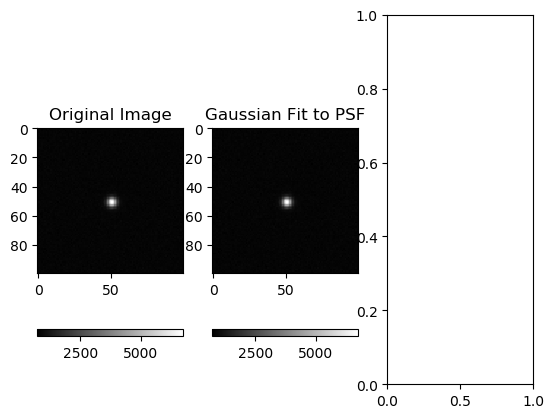

In [327]:
g=PSF_Test_Gaus2D(RA, Dec, Mag, '1.0', "2", 15.0)

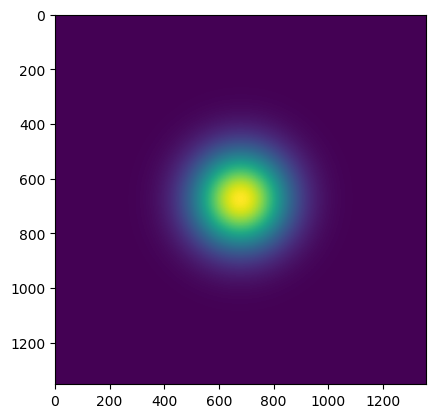

In [330]:
plt.imshow(g.render())